# Model-agnostic Explainable AI with DALEX

# Table of Contents

[Introduction](#Introduction)</br>
[DALEX](#DALEX)</br>
[Dataset](#Dataset)</br>
### Instance level exploration/explanation
[Instance level exploration/explanation](#ILEE)</br>
[Breakdown plots](#BP)</br>
[Shapley values](#SV)</br>
[LIME](#LIME)</br>
[LIME for text](#LIMET)</br>
[LIME for images](#LIMEI)</br>
[Ceteris-paribus profiles](#CPP)</br>
[Ceteris-paribus oscillations](#CPO)</br>
### Model level exploration/explanation
[Model level exploration/explanation](#MLEE)</br>
[Variable importance methods](#VIM)</br>
[Partial dependence](#PD)</br>
[Partial dependence with more dimensions](#PDWMD)</br>
[Counterfactual explanations](#CE)</br>


## Introduction

Model-agnostic explanation methods are methods that can be used to gain an insight in the behaviour of any model. Model-agnostic explanation methods are especially useful for black box models that are not interpretable by nature. 

By using the input and the prediction of any model, model-agnostic explainers can quantify the effect of a single input variable on the prediction. They can dentify interactions between different input variables, and they cn be used to answer questions like "Why is X classified differently than Y, while they are so similar?". 

Model-agnostic explainers only have information about the prediction of the model given certain input variables. This means that can not explain anything about the real world. They explain the model and thereby help us to understand the model.

## DALEX
For this course, we will mainly be using the DALEX (https://modeloriented.github.io/DALEX/) package. DALEX stands for mo<b>D</b>el <b>A</b>gnostic <b>L</b>anguage for <b>E</b>xploration and e<b>X</b>planation. THe DALEX package provides many easy methods to create model-agnostic explainers and visualisations.

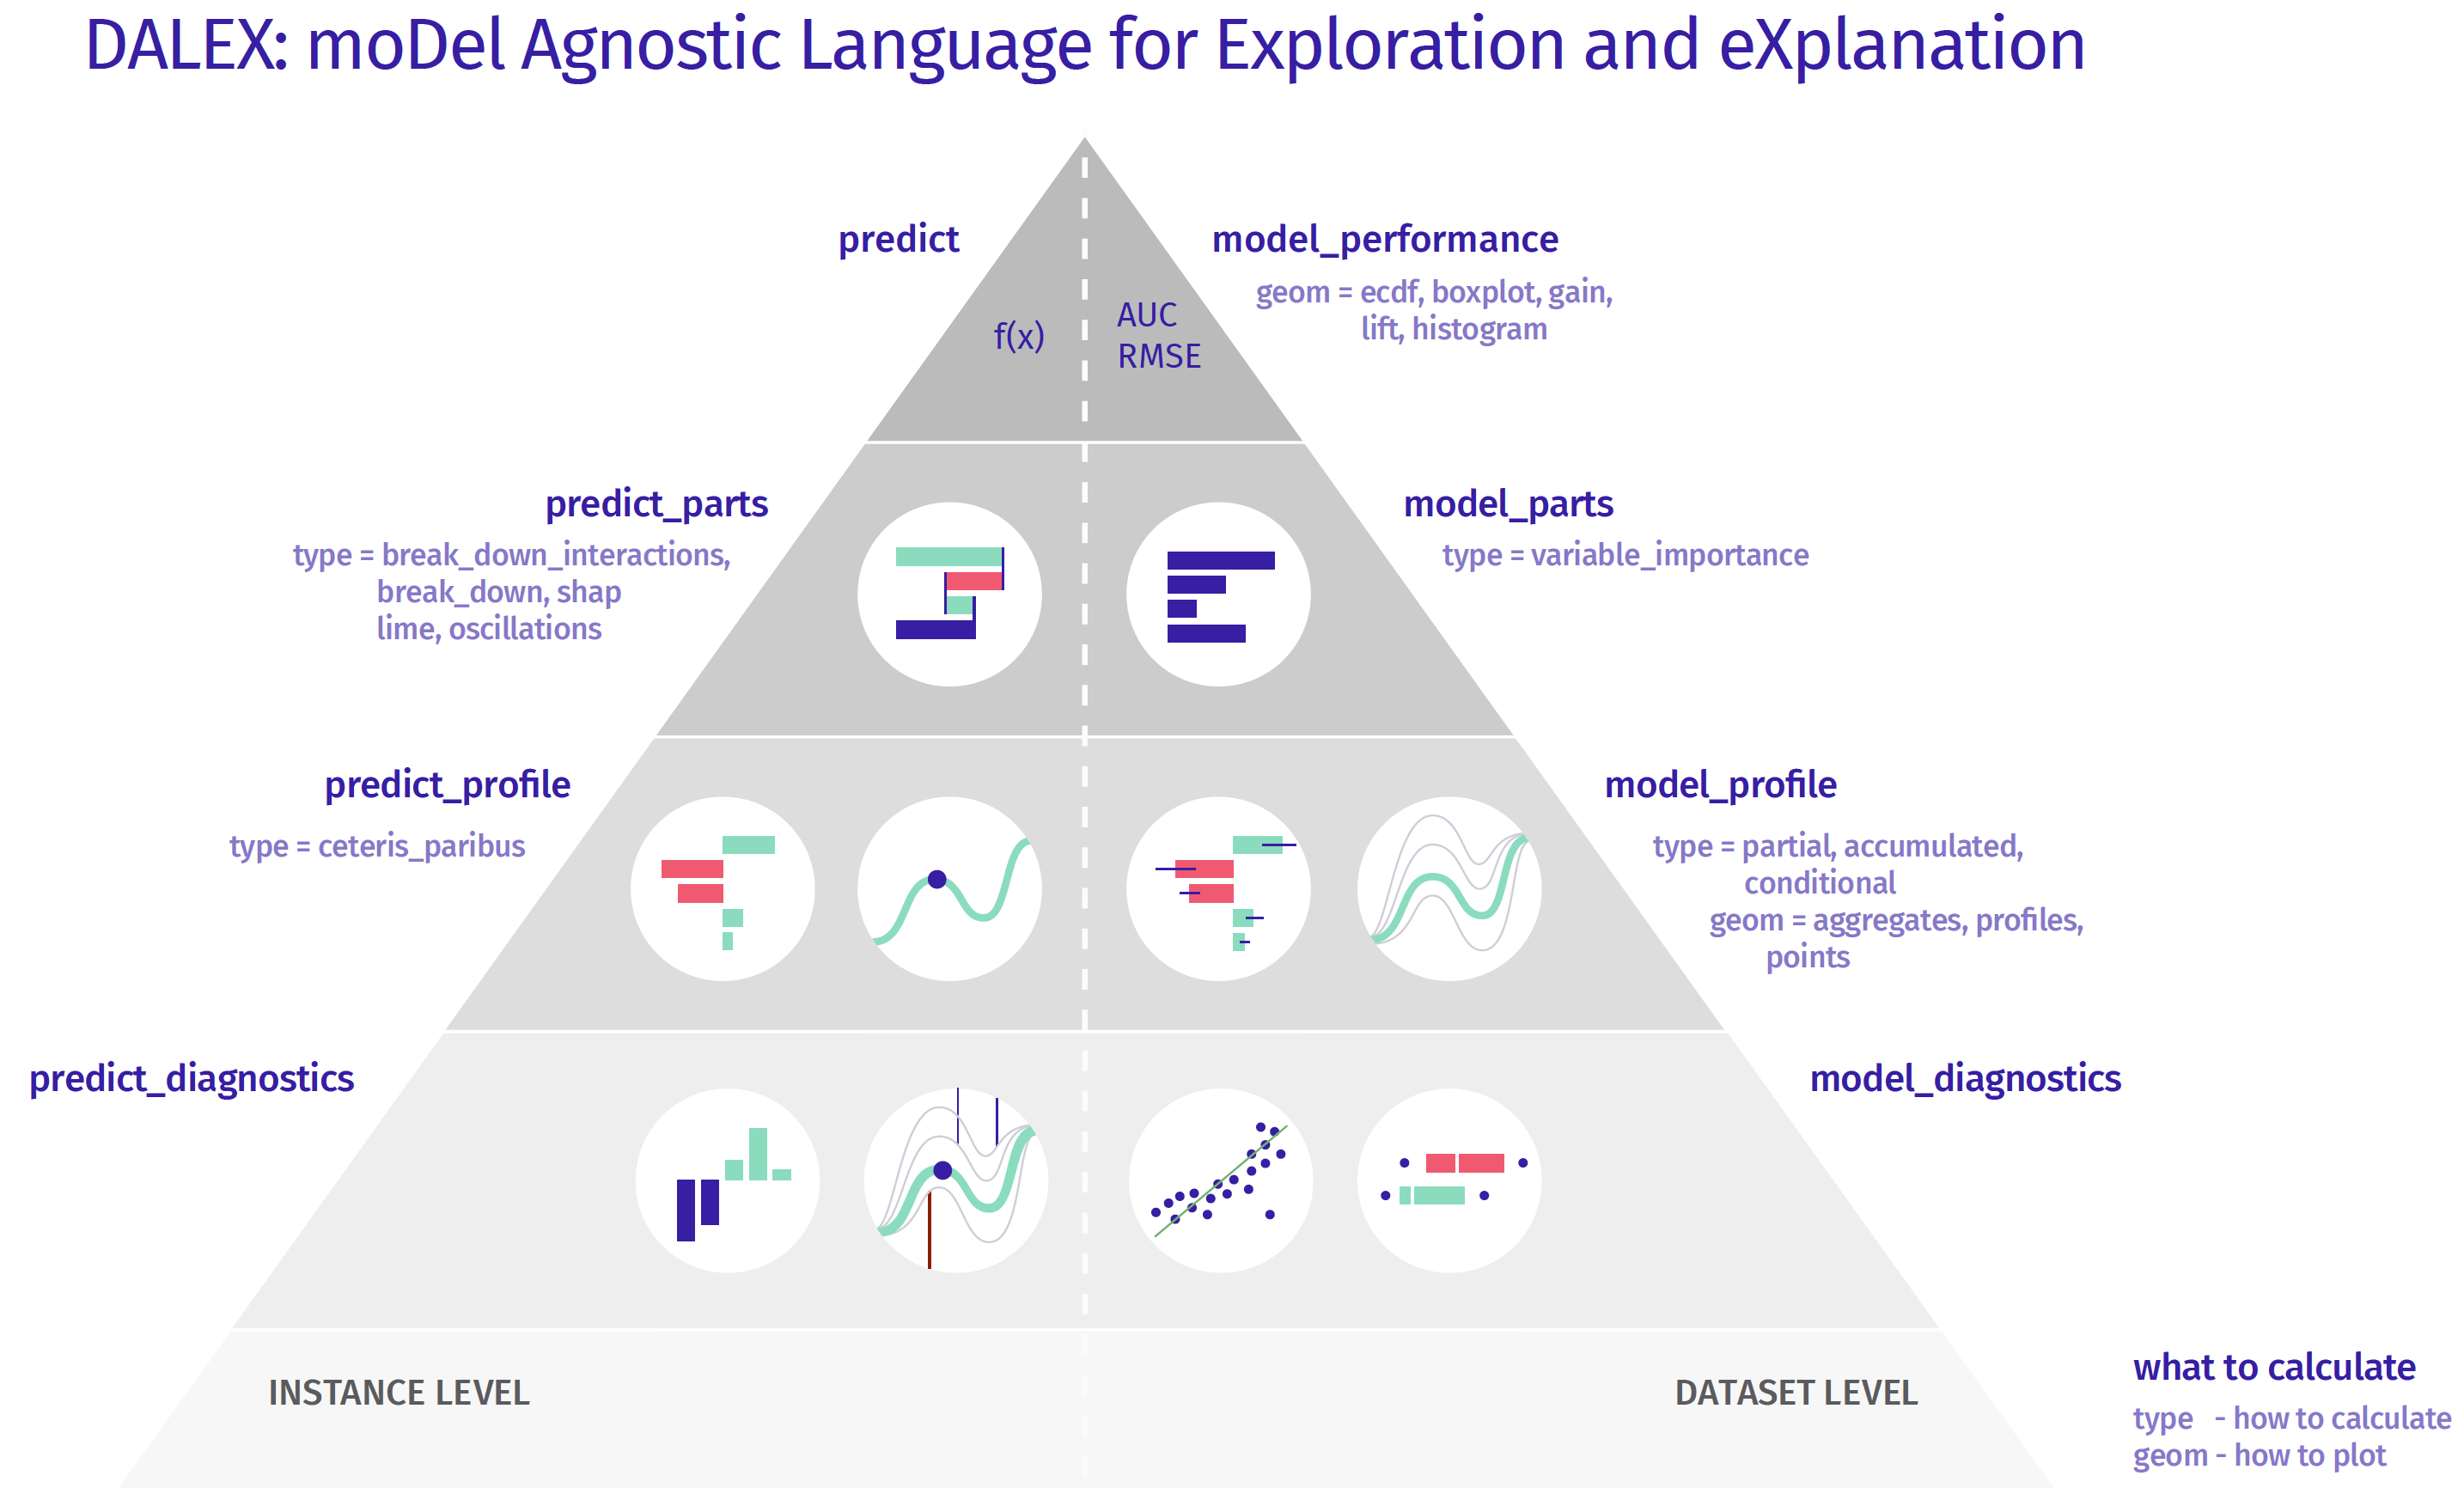

## Dataset
The dataset that we will use for the majority of this course is the California housing dataset from the StatLib repository: http://lib.stat.cmu.edu/datasets/. The target variable in this dataset is the median house value for a block group in California. A block group is a group of houses with a population of about 600 to 3000. The dataset uses the census data from 1990, and every datapoint represents a block group. There are eight explanatory variables in the dataset.

* <b>MedInc:</b> median income in block.
* <b>HouseAge:</b> median house age in block.
* <b>AveRooms:</b> average number of rooms.
* <b>AveBedrms:</b> average number of bedrooms.
* <b>Population:</b> block population.
* <b>AveOccup:</b> average house occupancy.
* <b>Latitude:</b> house block latitude.
* <b>Longitude:</b> house block longitude.

In [1]:
import itertools
import random
from collections import defaultdict
from random import sample

import dalex as dx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed(1)
sns.set(rc={'figure.figsize': (8, 8)})

Now we will load the dataset and split the data into train and test sets

In [2]:
# Load the dataset
data = fetch_california_housing(as_frame=True)

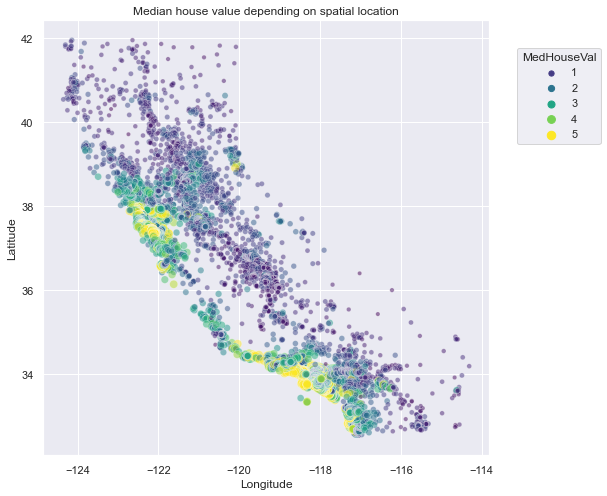

In [3]:
sns.scatterplot(data=data.frame, x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
_ = plt.title("Median house value depending on spatial location")

When plotting the latitude and longitude, the general shape of California becomes visible. 
We can also see that blocks near/in Los Angeles and San Fransisco have a higher median house value.

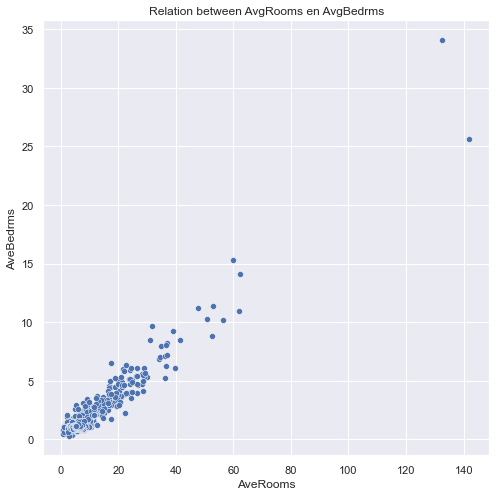

In [4]:
sns.scatterplot(data=data.frame, x="AveRooms", y="AveBedrms")
_ = plt.title("Relation between AvgRooms en AvgBedrms")

There appear to be some blocks with unrealisticly high numbers for the AveRooms and AveBedrms variables. 
When we filter on blocks with respective values of max 30 and max 7, we still have 99.9% of the data and remove those outliers.

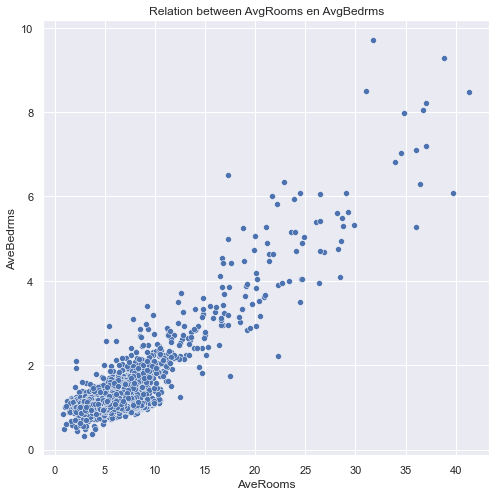

In [5]:
data.frame = data.frame[(data.frame.AveRooms < 50) & (data.frame.AveBedrms < 10)]
sns.scatterplot(data=data.frame, x="AveRooms", y="AveBedrms")
_ = plt.title("Relation between AvgRooms en AvgBedrms")

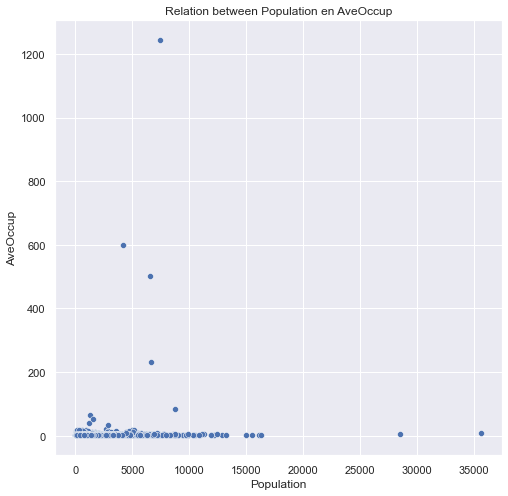

In [6]:
sns.scatterplot(data=data.frame, x="Population", y="AveOccup")
_ = plt.title("Relation between Population en AveOccup")

For Popualation and AveOccup, there appear to be some outliers too. 
We filter out the 12 most extreme datapoints by filtering on blocks that have a population of less then 17500 and where houses have less than 20 occupants on average.

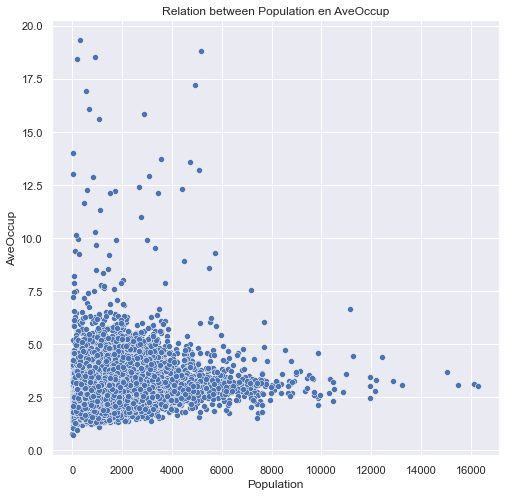

In [7]:
data.frame = data.frame[(data.frame.Population < 17500) & (data.frame.AveOccup < 20)]
sns.scatterplot(data=data.frame, x="Population", y="AveOccup")
_ = plt.title("Relation between Population en AveOccup")

Finally, we check house age and median income, and the target variable median house value for outliers.

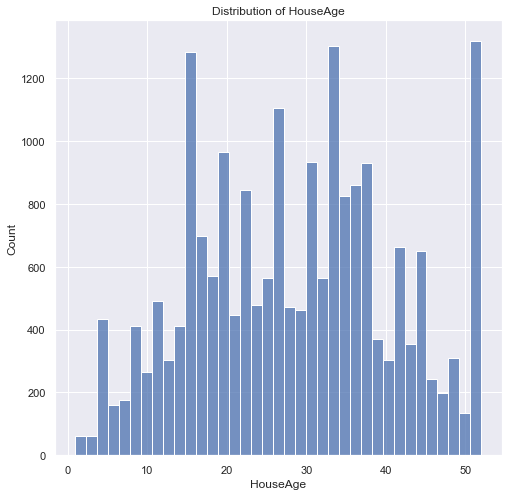

In [8]:
sns.histplot(data=data.frame, x="HouseAge")
_ = plt.title("Distribution of HouseAge")

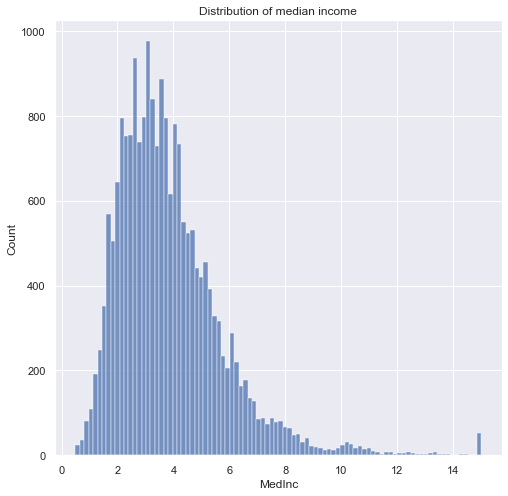

In [9]:
sns.histplot(data=data.frame, x="MedInc")
_ = plt.title("Distribution of median income")

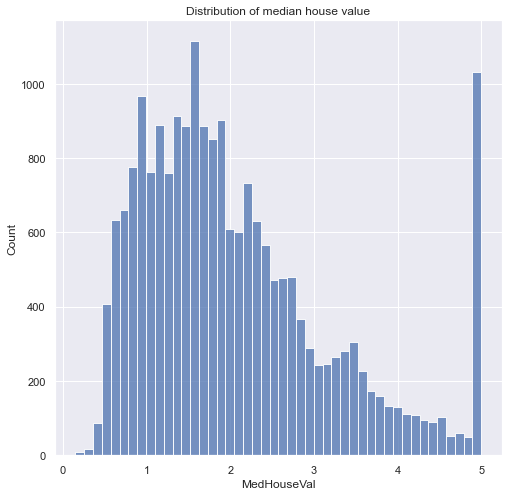

In [10]:
sns.histplot(data=data.frame, x="MedHouseVal")
_ = plt.title("Distribution of median house value")

These values, especially MedInc and MedHouseVal, appear to be capped. This however does not have to pose a problem for regression models, so we do not preprocess these values.

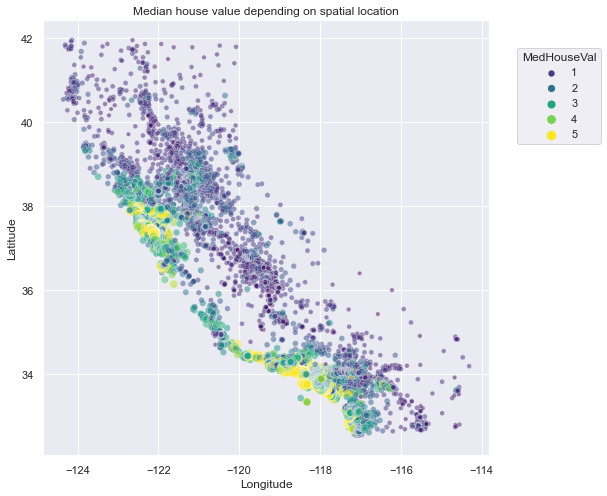

In [11]:
sns.scatterplot(data=data.frame, x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
_ = plt.title("Median house value depending on spatial location")

Now we will create the model that we are going to explain. This can be any model, but it makes most sense to choose a model that is not directly interpretable here. We will use a random forest model.

We will also create an observation that we will be going to explain.

In [12]:
# Split the data in train and test sets
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(data.frame[data.feature_names], 
                                                    data.frame[data.target_names].iloc[:,0], test_size=0.2)

In [13]:
np.random.seed(1)
model = RandomForestRegressor(random_state=0).fit(X_train, y_train)

In [14]:
X_test_sample = pd.DataFrame(X_test.iloc[1,:]).T
y_test_sample = y_test.iloc[1]

In [15]:
X_test_sample

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
9463     2.7      32.0   5.56338    1.06338       380.0  2.676056     39.44   

      Longitude  
9463    -123.73

In [16]:
y_test_sample

1.65

## Instance level exploration/explanation <a class="anchor" id="ILEE"></a>
The first collection of exploration methods we consider are the instance level explanation methods, also known as local explanation methods. These methods take a single datapoint as input, and explain how the model got to its prediction for this datapoint (only). 

Instance level exploration methods can be useful for a number of reasons:
* We want to assess the importance or contribution of the individual explanatory variables to the prediction. 
* We may want to comprehend the behavior of the model regarding chenges in the explanatory variables. If the population of a block were to be higher, what would that mean for this prediction? And if it were lower, would that make a difference?
* If a model performs poorly, we may want to find out why. If an expensive block is predicted to have a very low mean house value, it is interesting to see which explanatory variables, or which combination of explanatory variables, have caused this.

We start by creation an Explainer object. This is an object from the dalex package that can generate all sorts of explanations.

In [17]:
exp = dx.Explainer(model, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 16494 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 16494 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x000001DCFEA074C0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.411, mean = 2.08, max = 5.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.22, mean = -0.00437, max = 1.44
  -> model_info        : package sklearn

A new explainer has been created!


## Breakdown plots <a class="anchor" id="BP"></a>
A [breakdown plot](https://ema.drwhy.ai/breakDown.html) is an example of a local explanation method. A breakdown plot consists of a list of values, one for each predictor variable, and one for the intercept. A breakdown plot explains the contribution that each predictor variable has on the prediction. 

In the following example, we will first consider the contribution of the value for latitude on the prediction, then longitude, etc. In the second example, longitude and latitude are swapped, which gives different results.

In [18]:
breakdown = exp.predict_parts(X_test_sample,
                              type='break_down',
                              order=np.array(['Latitude', 'Longitude', 'AveRooms', 'AveBedrms', 
                                              'Population', 'AveOccup', 'HouseAge', 'MedInc']),
                              random_state=1)
breakdown.plot()

In [19]:
breakdown = exp.predict_parts(X_test_sample,
                              type='break_down',
                              order=np.array(['Longitude', 'Latitude', 'AveRooms', 'AveBedrms', 
                                              'Population', 'AveOccup', 'HouseAge', 'MedInc']),
                              random_state=1)
breakdown.plot()

So the order of things matters. When latitude was set to be the first variable considered, it caused a decrease in average response of 0.535. When we first considered longitude and latitude secondly, the contribution of latitude was -0.999, that is almost twice as much. This behaviour of breakdown plots in inherent to how a breakdownplot works. In a breakdown plot, we consider a subset of the data after fixing certain variables. 

Imagine a region in which the mean house values are high in the north-east and in the south-west, and low in the north-west and south-east. Neither latitude nor longitude will directly give information about the mean house value on its own. This means that the one that is added to the breakdown plot first, will not show a large absolute contribution no matter its value. Only if we know that the latitude is high for example, meaning we are looking at blocks in the north, then the value for longitude will show a large absolute contribution. 

In the previous two examples, we quantified the additive contributions of each variable. In a similar fashion, we could also look at the contribution of two variables at the same time, which results in a [breakdown plot for interactions](https://ema.drwhy.ai/iBreakDown.html). If we combine Latitude and Longitude, we will get the contribution of 'location' to the the final prediction. Note that the contribution of Longitude:Latitude is equal to the sum of the contributions of the two in the previous breakdown plots. This only works because in both cases, latitude and longitude are the first variables considered, either individually, or together.

In [20]:
breakdown_interaction_10 = exp.predict_parts(X_test_sample,
                                             type='break_down_interactions',
                                             interaction_preference=10,
                                             random_state=1)
breakdown_interaction_10.plot()

To illustrate the effect that has on the different contribution values for different variables, we calculate the contribution values for 50 random orderings of variables. This may take a couple of minutes to complete.

In [21]:
n = 50
random.seed(1)
contributions = defaultdict(lambda: [])
for ordering in tqdm(sample(list(itertools.permutations(data.feature_names)), n)):
    breakdown = exp.predict_parts(X_test_sample, type='break_down', order=list(ordering))
    for item in list(zip(breakdown.result.variable_name, breakdown.result.contribution))[1:-1]:
        contributions[item[0]].append(item[1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:51<00:00,  7.04s/it]


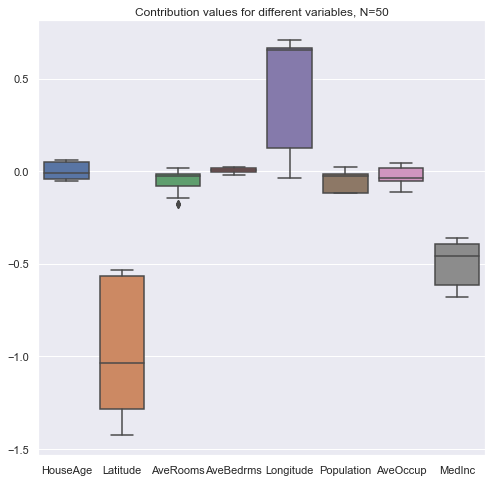

In [22]:
sns.boxplot(data=pd.DataFrame(contributions))
_ = plt.title(f'Contribution values for different variables, N={n}')

As we can see, some variables have high variability in contribution value depending on the ordering the variables are presented in. It would be useful to be able to quantify the contribution of a variable to a prediction using only a single value. This is what [Shapley values](https://ema.drwhy.ai/shapley.html) are used for. 

## Shapley values <a class="anchor" id="SV"></a>

[Shapley values](https://ema.drwhy.ai/shapley.html) come from game theory and aim to estimate a player's contribution to the result of a game. In explanatory modeling, Shalpey values elegantly estimate the contribution of a variable to the final prediction. 

Shapley values are computed by taking the average of many predictions where different combinations of all other variables than the one we are computing the Shapley value for, are considered. A combination means that we leave some of the other variables in, while replacing others by randomly sampled values from (training-)data. To compute the exact Shapley value, all combinations of other predictor variables should be considered. This is unfeasable for models with many explanatory variables, since the amount of combinations to be considered grows exponentially with the number of variables. For all other variables, we either leave them in, or replace them, meaning that the amount of combinations is equal to 2 to the power of number of other variables. For every combinations, we need to sample multiple times as well to get a reliable value for the margnal value if the variable the that combination.

Since using all combinations is oftem infeasible, we can also sample a number of combinations to consider, this makes calculating (estimated) Shapley values doable.

In [23]:
shapley_values = exp.predict_parts(X_test_sample, type='shap', random_state=1)
shapley_values.plot()

## More variables
Breakdown plots and Shapley values are a good way to locally explain models that do not have a lot of variables, and that have easily interpretable variables. For models with more variables, differents methods are more suitable. 

## Local Interpretable Model-agnostic Explanations (LIME) <a class="anchor" id="LIME"></a>
[LIME](https://ema.drwhy.ai/LIME.html) is a method that fits an interpretable model, for example a linear regression model, on generated data. The data this model is trained on, is generated by permuting the training data. Data that is similar to the datapoint of which we want to explain the prediction in a black-box model is weighted more heavily and thus contributes more the the final model. This is where the L(ocal) in LIME comes from. The interpretable local model, can provide an explanation on why a certain prediction was made in this case.

If the dataset we were looking at only contained latitude and longitude as explanatory variables, a local model could be seen as a model explaining the predictions of a region, or even a city, only. In a state, the expensive cities may be located in the eastern part, but within these cities, the most expensive neighborhoods may be located in the western part of the city. A LIME explainer - given that the parameters are set correctly - could be able to show the effect high longitude (western part of the city) has on the prediction.

In [24]:
explainer = LimeTabularExplainer(X_train,
                                 mode="regression",
                                 feature_names=X_train.columns,
                                 discretize_continuous=False,
                                 verbose=True,
                                 random_state=1,
                                 kernel_width=1)
lime = explainer.explain_instance(X_test_sample.iloc[0, :], model.predict)

Intercept 2.174492248098745
Prediction_local [1.70100553]
Right: 0.8860800000000002


In [25]:
# lime.as_pyplot_figure()
lime.show_in_notebook(show_table=True)

## LIME for text <a class="anchor" id="LIMET"></a>
The LIME method can also be used for text classification. LIME for text is very similar to LIME for tabular data. In this case, the explanatory model is trained on sentences that are similar to the sentence we want to explain. 

For a movie review dataset, we may want to explain the model's behaviour regarding the review: "This movie was not bad at all.". To do this, we can fit a model on the datapoints: 
"movie was not bad at all.",  
"This was not bad at all.",  
"This movie not bad at all.", etcetera. Of course, the similarity function is free to choose, and instead of leaving a word out per newly generated datapoint, we could also replace words, or leave two words out for example.

In [26]:
import os

import pandas as pd
import tensorflow as tf
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [27]:
# Get the IMDB movie review dataset
dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz",
                                  origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

In [28]:
# Organise the data
df = pd.DataFrame([], columns=['question_text', 'target'])
for file in os.listdir(os.path.join('aclImdb', 'test', 'neg')):
    with open(os.path.join('aclImdb', 'test', 'neg', file), encoding="utf-8") as f:
        df = df.append(pd.DataFrame([[f.readlines()[0], 0]], columns=['question_text', 'target']))

for file in os.listdir(os.path.join('aclImdb', 'test', 'pos')):
    with open(os.path.join('aclImdb', 'test', 'pos', file), encoding="utf-8") as f:
        df = df.append(pd.DataFrame([[f.readlines()[0], 1]], columns=['question_text', 'target']))

print("Dataframe shape : ", df.shape)

Dataframe shape :  (25000, 2)


In [29]:
# Split to train and val
train_df, val_df = train_test_split(df, test_size=0.1, random_state=1)
val_df.reset_index(drop=True)

# Vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df=10, max_features=100000, analyzer="word", ngram_range=(1, 2), stop_words='english',
                           lowercase=True)
train_vc = tfidf_vc.fit_transform(train_df["question_text"])
val_vc = tfidf_vc.transform(val_df["question_text"])

In [30]:
# Train model and print F1 score on validation set
text_model = LogisticRegression(C=0.5, solver="sag")
text_model = text_model.fit(train_vc, train_df.target.astype('int'))
val_pred = text_model.predict(val_vc)

val_cv = f1_score(val_df.target.astype('int'), val_pred, average="binary")
print(val_cv)

0.89171974522293


In [31]:
# Select review (or use custom one)
idx = 1000
class_names = ["negative", "positive"]
# review_text = val_df["question_text"].iloc[idx]
review_text = "This movie was not bad at all. It was very enjoyable and featured some interesting characters."
# true_class = class_names[val_df["target"].iloc[idx]]
true_class = "positive"

# Make pipeline and explainer model
c = make_pipeline(tfidf_vc, text_model)
explainer = LimeTextExplainer(class_names=class_names)
exp_instance = explainer.explain_instance(review_text, c.predict_proba, num_features=5)

# Show review text, predictions, and label
print("Review: \n", review_text)
print("Probability (Negative) =", c.predict_proba([review_text])[0, 0])
print("Probability (Positive) =", c.predict_proba([review_text])[0, 1])
print("True Class is:", true_class)

# exp_instance.as_pyplot_figure()
exp_instance.show_in_notebook(text=review_text, labels=(1,))

Review: 
 This movie was not bad at all. It was very enjoyable and featured some interesting characters.
Probability (Negative) = 0.8210423053058047
Probability (Positive) = 0.1789576946941953
True Class is: positive


## LIME for images <a class="anchor" id="LIMEI"></a> 

LIME can also be applied to image data. LIME for images work somewhat differently than LIME for tabular data or textual data. Instead of randomly permuting variables or words, LIME for images uses different combinations of superpixels to work with. A superpixel is a part of an image consisting of neighboring pixels. If 100 superpixels are identified in an image, LIME for images can then use random combinations of these superpixels to generate data. This will result in part of the original image being displayed and part of it being turned off. ome images will still be correctly classified. THis probably means that the visible part of the image contained important information for the classifier te recognise a certain class. By keeping track of the images that are correctly identified by the model, we can identify the most important superpixels.

In [32]:
import os

import numpy as np
import skimage
from lime import lime_image
from matplotlib import pyplot as plt
from skimage import io, transform
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [33]:
inet_model = inc_net.InceptionV3()
image = skimage.io.imread(os.path.join('data', 'cat_image.jpg'))
img = skimage.transform.resize(img, (299, 299))
img = (img - 0.5) * 2
img = np.expand_dims(img, axis=0)
preds = inet_model.predict(img)
for i in decode_predictions(preds)[0]:
    print(i)

NameError: name 'img' is not defined

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img[0].astype('double'), inet_model.predict,
                                         top_labels=3, hide_color=0, num_samples=500)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5,
                                                hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10,
                                                hide_rest=False)
temp_3, mask_3 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10,
                                                hide_rest=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(img[0])
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax3.imshow(mark_boundaries(temp_3, mask_3))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

The image on the left is the original image. The image in the middle shows the explanation for 'tabby', and the image on the right shows the explanation for 'tiger cat'. The green areas show the superpixels that explain the decision.

## Ceteris-paribus profiles <a class="anchor" id="CPP"></a>
[Ceteris-paribus profiles](https://ema.drwhy.ai/ceterisParibus.html) are a way to quantify the effect that changing one variable has on the prediction. In a ceteris-paribus profile, all variables except for one are fixed. The resulting profile show the prediction for all possible values of that one variable that is not fixed.

In [ ]:
cp_sample = exp.predict_profile(X_test_sample)

In [ ]:
cp_sample.result

In [ ]:
cp_sample.plot()

In the plot with the ceteris-paribus profile of MedInc, we can see that changing MedInc to a value of 7.895, would dramatically increase the prediction. After manually changing this value and having the model predict again, we can see that this is exactly what happens.

In [ ]:
X_test_sample_high_medinc = X_test_sample.copy()
X_test_sample_high_medinc['MedInc'] = 7.895
model.predict(X_test_sample_high_medinc)

Ceteris-paribus profiles are a measure of variable importance in a way, since they tell how much one predictor variable can change the outcome variable. A relatiely horizontal ceteris-paribus profile means that the input variable does not really affect the output variable a lot. In other words, it means the input variable can change all it wants, it would not really affect the outcome variable. The ceteris-paribus profile of HouseAge is an example of this. 

A variable with a ceteris-paribus profile with (steeper) slopes can have more of an effect on the outcome variable. The ceteris-paribus profile of MedInc shows a steep slope. From this profile, we can read that a change in MedInc to 8 or more, would increase the outcome variable from about 1 to about 4.

## Ceteris-paribus oscillations <a class="anchor" id="CPO"></a>

To quantify the importance of a variable, or its ability to affect the outcome variable, we use [ceteris-paribus oscillations](https://ema.drwhy.ai/ceterisParibusOscillations.html). These oscillations are measures of how different the outcome can be if we were to change the input variable. The oscillations are the sum of the differences between the ceteris-paribus profile and the horizontal line y=y_pred. Using the average of oscillations, the most important variables can be identified.

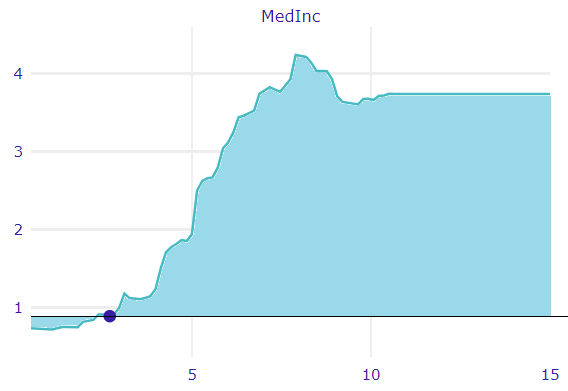

In this picture, the blue area represent the oscillations for the MedInc variable. The average of oscillations is quite high, because the observed data point has a relatively low value for MedInc, and raising it just a bit (or a lot) will increase the rediction for mean house value quickly.

In [ ]:
## CP oscillations
prediction = model.predict(X_test_sample)
cp_sample_res = exp.predict_profile(X_test_sample).result

In [ ]:
cp_oscillations_unif = {}
cp_oscillations_emp = {}
for feature in data.feature_names:
    feature_sublist = cp_sample_res[cp_sample_res._vname_ == feature]
    feature_value_list = feature_sublist[feature].values
    cp_oscillations = (feature_sublist._yhat_ - prediction).values
    cp_oscillations_abs = np.abs(cp_oscillations)
    step_size = feature_value_list[-1] - feature_value_list[-2]
    emp_corr = [len(X_train[(feature_value - step_size * 0.5 < X_train[feature]) &
                            (X_train[feature] < feature_value + step_size * 0.5)]) / len(X_train)
                for feature_value in feature_value_list]
    cp_oscillations_unif[feature] = cp_oscillations_abs / len(feature_sublist)
    cp_oscillations_emp[feature] = cp_oscillations_abs * emp_corr

In [ ]:
data_unif = pd.DataFrame([(k, sum(v)) for k, v in cp_oscillations_unif.items()])
data_unif.columns = ['var', 'oscillations']
sns.barplot(x="oscillations", y="var", data=data_unif.sort_values(by=['oscillations'], ascending=False, axis=0), color='lightblue')
_ = plt.title("cp oscillations for uniform distribution")
plt.show()

Ceteris-paribus oscillations show the importance of single input variables. In the ceteris-paribus plot of MedInc, we can see that having a higher MedInc will result in a much higher predicted MedHouseVal. This is also reflected in the plot above, showing an average oscillation of about 2 for MedInc. 

There however is one caveat with this method; many values are very unlikely for the input variables, since the vast majority of MedInc values is between 2 and 6. We can adjust for this by sampling according to the distribution of the training set and thus counting the oscillations in realistic ranges more heavily. If we do this, we see the average oscillation of MedInc drop from about 2 to about 0.7. This happens because the largest oscillations are at MedInc values 10-15, which are very unlikely. By factoring in the rarity of the occurence of high MedInc values (with high oscillations), we diminish the effect on the final 'oscillations score'.

In [ ]:
data_emp = pd.DataFrame([(k, sum(v)) for k, v in cp_oscillations_emp.items()])
data_emp.columns = ['var', 'oscillations']
sns.barplot(x="oscillations", y="var", data=data_emp.sort_values(by=['oscillations'], ascending=False, axis=0), color='lightblue')
_ = plt.title("cp oscillations for empirical distribution")
plt.show()

## Model level exploration/explanation <a class="anchor" id="MLEE"></a>
Next to the instance level explanation methods, there also are model level explanation methods. These explanation methods aim to explain the entire model.

## Variable importance methods <a class="anchor" id="VIM"></a>
[Variable importance methods](https://ema.drwhy.ai/featureImportance.html) are methods to assess the importance of a variable in a model. Permutation-based variable importance randomly shuffles the values for one predictor variable around and then predicts the outcome variable. If the predictor variable was really important, the model will perform badly after the permutation and the loss will rise. If the predictor that has been permtated was not important for the prediction, the loss will rise relatively little. The difference in loss between predictions made with the original data, and predictions made with permutated data, can be used as a quantification for variable importance in the model.

In [ ]:
mp_rf = exp.model_parts()
mp_rf.plot()

In [ ]:
mp_rf_grouped = exp.model_parts(variable_groups={'Location': ['Latitude', 'Longitude'],
                                                 'House': ['AveBedrms', 'AveRooms', 'HouseAge'],
                                                 'People': ['Population', 'MedInc', 'AveOccup']})
mp_rf_grouped.plot()

## Partial dependence <a class="anchor" id="PD"></a>
[Partial dependence plots](https://ema.drwhy.ai/partialDependenceProfiles.html) are in a way summaries of ceteris-paribus profiles. In the plots below, the partial dependence profile (cyan line) is plotted alongside the individual ceteris-paribus profiles (grey lines). The partial dependence profile is a good summary of the ceteris-paribus profiles.

In [ ]:
partial_dependence = exp.model_profile(variables = ['MedInc', 'AveOccup'], N=100)
partial_dependence.plot(geom = 'profiles')

## Partial dependence with more dimensions <a class="anchor" id="PDWMD"></a>
Partial dependence profiles (as can ceteris-paribus profiles) can be constructed for any dimension size. More that 2-D would be hard to visualise and therefore we will, next to the single variable partial dependence profile, only consider the two-variable partial dependence profile. In this example, the partial dependence profiles of Longtitude, Latitude, and Longtitude x Latitude combined are plotted. In the latter plot, we can see that the model generally predicts higher MeanHouseVals for values in the south-west. This makes sense, since the model has probably learnt about the high MedHousVals in the larger cities at the coast.

In [ ]:
sns.set(rc={'figure.figsize':(16, 6)})
plot_partial_dependence(model, X_train, ['Longitude','Latitude', ['Longitude','Latitude']])

## Counterfactual explanations <a class="anchor" id="CE"></a>

Instead of explaining why a certain decision has been made, it othen can be interesting to find out how we can cause another decision/prediction to be made. In other words: How can we make the model change its mind? This can be useful to find out whether or not the model is correct and robust. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from alibi.explainers.counterfactual import CounterFactual
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

np.random.seed(1)
sns.set(rc={'figure.figsize': (8, 8)})
tf.compat.v1.disable_eager_execution()

In [ ]:
# Load the dataset and organise data
data = fetch_california_housing(as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(data.frame[data.feature_names],
                                                    data.frame[data.target_names].iloc[:, 0], test_size=0.2)
y_train_med = y_train.median()
y_train_bool = y_train.apply(lambda x: True if x > y_train_med else False)
y_test_bool = y_test.apply(lambda x: True if x > y_train_med else False)

# Select a sample from the data
X_test_sample = pd.DataFrame(X_test.iloc[1, :]).T
y_test_sample = y_test_bool.iloc[1]

In [ ]:
# Train (and evaluate) a classifier
model = RandomForestClassifier(random_state=0).fit(X_train, y_train_bool)
model.score(X_test, y_test_bool)

After artificially raising MedInc, we get a new datapoint:

In [ ]:
# Customise the sample and make a prediction for it
X_test_sample_high = X_test_sample.copy()
X_test_sample_high.MedInc = 4.2
model.predict(X_test_sample_high)

This block is expected to have a higher MedHouseVal then the median of blocks in the training data.

In [ ]:
print(f'above median house prices: {model.predict(X_test_sample_high)[0]}')

In [ ]:
# Create a CounterFactual object, and generate an explanation for it
counterfactual = CounterFactual(predict_fn=model.predict_proba, shape=X_test_sample_high.shape)
explanation = counterfactual.explain(np.array(X_test_sample_high))

In [ ]:
# Create a dataframe containing the counterfactual, and a scaled version of it with respect to the original
cf_df_original = pd.DataFrame(explanation.cf['X'])
cf_df_original.columns = X_test_sample_high.columns
cf_df_scaled = pd.DataFrame(explanation.cf['X'] / X_test_sample_high.values)
cf_df_scaled.columns = X_test_sample_high.columns

In [ ]:
X_test_sample_high

In order to flip the prediction, the main thing we have to change is the MedInc of the datapoint. If we lower this value to 3 (and tweak some others a bit), the prediction will flip.

In [ ]:
cf_df_original

In [ ]:
# Create a dataframe denoting the change in the original values
# that needs to take place in order to get a different prediction
change = pd.DataFrame([(c, v) for c, v in zip(cf_df_scaled.values[0], cf_df_scaled.columns)])
change.columns = ['Change', 'Variable']

In [ ]:
# Create a visual of this change
sns.barplot(x="Variable", y="Change", data=change.sort_values(by=['Variable'], ascending=False, axis=0),
            color='lightblue')
_ = plt.title("Change needed to get a counterfactual example")
plt.show()